In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline

In [5]:
df=pd.read_csv('/Users/pein/Desktop/train2.csv').fillna('')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


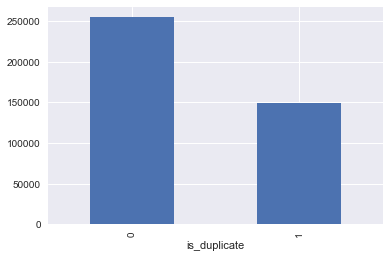

In [7]:
df.groupby('is_duplicate')['id'].count().plot.bar()

### Feature Construction

In [8]:
dfs=df[:2500]

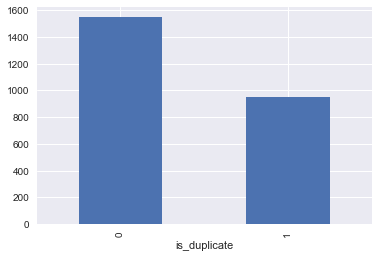

In [9]:
dfs.groupby('is_duplicate')['id'].count().plot.bar()

In [10]:
# The sample has very smaily label distribution

In [17]:
dfq1,dfq2=dfs[['qid1','question1']],dfs[['qid2','question2']]
dfq1.columns=['qid1','question']
dfq2.columns=['qid2','question']

#merge two dfs,there are two nans for question
dfqa=pd.concat((dfq1,dfq2),axis=0).fillna('')
nrows_for_q1=dfqa.shape[0]/2
dfqa.shape

(5000, 3)

In [18]:
dfqa.tail()

,qid1,qid2,question
2495,,4959,How GDP might be a misleading measure of stand...
2496,,4961,How are Chinese names converted to Japanese?
2497,,4963,What would happen if both Donald Trump and Mik...
2498,,4965,Do employees at MTS Systems have a good work-l...
2499,,4966,What are some of the best blogs on Quora?


In [16]:
# Transform questions by TF_IDE

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
mql=TfidfVectorizer(max_features=256).fit_transform(dfqa['question'].values)
mql

<5000x256 sparse matrix of type '<class 'numpy.float64'>'
	with 31365 stored elements in Compressed Sparse Row format>

# since we are looking at the pari of the data,we will be taking the difference of all question one and question two

In [24]:
diff_encoding=np.abs(mql[::2]-mql[1::2])
diff_encoding

<2500x256 sparse matrix of type '<class 'numpy.float64'>'
	with 29265 stored elements in Compressed Sparse Row format>

# 3D t-SNE embedding

In [29]:
from sklearn.manifold import TSNE
tsne=TSNE(
    n_components=3,
    init='random',
    random_state=101,
    method='barnes_hut',
    n_iter=200,
    verbose=2,
    angle=0.5).fit_transform(diff_encoding.toarray())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.466567
[t-SNE] Iteration 25: error = 1.6904477, gradient norm = 0.0103142
[t-SNE] Iteration 50: error = 1.6138078, gradient norm = 0.0104772
[t-SNE] Iteration 75: error = 1.3103828, gradient norm = 0.0031830
[t-SNE] Iteration 100: error = 1.2546983, gradient norm = 0.0045287
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.254698
[t-SNE] Iteration 125: error = 1.1571782, gradient norm = 0.0009612
[t-SNE] Iteration 125: gradient norm 0.000961. Finished.
[t-SNE] Error after 125 iterations: 1.254698


In [31]:
import plotly.graph_objs as go
tracel = go.Scatter3d(
x = tsne[:,0],
y = tsne[:,1],
z = tsne[:,2],
mode='markers',
marker=dict(sizemode='diameter',
color = dfs['is_duplicate'].values,
colorscale = 'Portland',
)
)
data=[tracel]
layout=dict(height=800,width=800,
            title='test')
fig=dict(data=data,layout=layout)
py.ipot(fig,filename='3DBubble')


ModuleNotFoundError: No module named 'plotly'

#Feature EDA

In [32]:
# construct 1.length of the question 1 and 2
#           2. number of worlds in question 1 and 2
#           3. normalized word share count

In [37]:
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()

df['q1_n_words']=df['question1'].apply(lambda x:len(x.split(" ")))
df['q2_n_words']=df['question2'].apply(lambda x:len(x.split(" ")))

def normalized_word_share(x):
    w1=